# TITLE

# Introduction

Our project will use LDA on movies' synopsis to group the movies into themes. In this notebook, we will start from the raw movies dataset and add the synopsis, the ratings and the box-offices from other datasets. We then perform an in-depth analysis of the obtained dataset to understand what we have in hands. We finish with a quick feasibility-check of the LDA method.

<div style="border-left: 6px solid rgba(69, 157, 185, 1);border-radius:5px; box-shadow: 3px 3px 3px rgba(221, 221, 221, 1);" >
    <p style="background-color: rgba(69, 157, 185, 0.1); font-weight:bold; padding: 8px 0 8px 15px;">Analysis</p>
    <div style="padding: 0 0 2px 10px;">
    
**What will be covered :**
- **Part 1 :** Data Exploration and Processing
- **Part 2 :** Data Analysis
- **Part 3 :** Is LDA a feasible method for our data ?

</div></div>
<br/>

---

# Part 1: Data Exploration and Processing

### Import libraries

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import matplotlib.ticker as mtick
import plotly.graph_objects as go
import ast

# LDA
import spacy
import nltk
#nltk.download('punkt')
#nltk.download('stopwords')
# gensim is a popular library for topic modelling
from gensim.corpora import Dictionary
from gensim.models import LdaModel
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import pickle


from imdb import IMDb
import re
import kagglehub # To extract synopsis dataframes





## 1.1 Dataset exploration 

### Load initial movie dataset

In [22]:
movie_columnns =['Wikipedia movie ID','Freebase movie ID', 'Movie name', 'Movie release date', 'Movie box office revenue', 'Movie runtime', 'Movie languages', 'Movie countries', 'Movie genres']
movie = pd.read_csv('data/movie.metadata.tsv', sep='\t', header=None, names=movie_columnns)
print('The dataset contains', movie.shape[0], 'movies and',movie.shape[1] , 'features')
movie.head()

The dataset contains 81741 movies and 9 features


,Wikipedia movie ID,Freebase movie ID,Movie name,Movie release date,Movie box office revenue,Movie runtime,Movie languages,Movie countries,Movie genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"


## Features Descriptions

| Column                | Description                                                                        |
|-----------------------|------------------------------------------------------------------------------------|
| Wikipedia movie ID    | An identifier for each movie from Wikipedia.                                       |
| Freebase movie ID     | A unique identifier for each movie from the Freebase database.                     |
| Movie name            | The title of the movie.                                                            |
| Movie release date    | The date when the movie was released, formatted as `YYYY-MM-DD`.                   |
| Movie box office revenue | The revenue generated by the movie at the box office (in dollars). |
| Movie runtime         | The duration of the movie in minutes. |
| Movie languages       | A dictionary where keys represent Freebase language IDs, and values represent the language names (e.g., English, Norwegian, German). |
| Movie countries       | A dictionary where keys are Freebase country IDs, and values are country names representing where the movie was produced. |
| Movie genres          | A dictionary where each key represents a Freebase genre ID, and each value represents the corresponding genre of the movie. |

### Comment
Not all features will be useful to our analysis:
- The `Freebase movie ID` is no longer actively
- `Movie runtime` is not used in the analysis
So both of those features will be dropped

#### Drop columns

In [5]:
# Creat new df with updated columns
movie_drop = movie.drop(['Freebase movie ID', 'Movie runtime'], axis=1)

# Visual check
movie_drop.columns

Index(['Wikipedia movie ID', 'Movie name', 'Movie release date',
       'Movie box office revenue', 'Movie languages', 'Movie countries',
       'Movie genres'],
      dtype='object')

Both columns have been efficently dropped

## Features types

In [7]:
pd.DataFrame(movie_drop.dtypes, columns=['Type'])

,Type
Wikipedia movie ID,int64
Movie name,object
Movie release date,object
Movie box office revenue,float64
Movie languages,object
Movie countries,object
Movie genres,object


### Comment
1. The `Movie languages`, `Movie countries` and `Movie genres` are stored in dictionnaries with `Freebase movie ID` as keys. Since the `Freebase movie ID` are not kept the dictionnaries will be changed and to keep values only.

2. For our analysis, having the full release date in `Movie name` isn't necessary, just the year is enough. Therefore, we convert the release date into a year format (e.g. 1995-07-21 becomes 1995).

We decide to remove the Freebase movie ID as it is no longer actively used and since for our analysis we are not interested in the movie runtime we drop this column too. 

In [8]:
def convert_to_list(df, column_name):
    #Convert to dictionnary 
    df[column_name] = df[column_name].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
    #Convert to list
    df[column_name] = df[column_name].apply(lambda x: list(x.values()) if isinstance(x, dict) else None)
    return df[column_name]

In [13]:
movies_df = movie_drop.copy()
movies_df['Movie genres'] = convert_to_list(movies_df, 'Movie genres')
movies_df['Movie languages'] = convert_to_list(movies_df, 'Movie languages')
movies_df['Movie countries'] = convert_to_list(movies_df, 'Movie countries')

movies_df[['Movie genres','Movie languages', 'Movie countries']].head()

,Movie genres,Movie languages,Movie countries
0,"[Thriller, Science Fiction, Horror, Adventure,...",[English Language],[United States of America]
1,"[Mystery, Biographical film, Drama, Crime Drama]",[English Language],[United States of America]
2,"[Crime Fiction, Drama]",[Norwegian Language],[Norway]
3,"[Thriller, Erotic thriller, Psychological thri...",[English Language],[United Kingdom]
4,[Drama],[German Language],[Germany]


We can now see that the columns containing information about movie languages, countries, and genres are indeed formatted as lists. 

In [14]:
def extract_year(value):
    # Check if the value is a year (4-digit number) and return it as is
    if isinstance(value, int) or (isinstance(value, str) and value.isdigit() and len(value) == 4):
        return int(value)
    # Try to convert complete date strings to datetime and extract the year
    try:
        return pd.to_datetime(value).year
    except (ValueError, TypeError):
        return np.nan  # Return NaN if conversion fails

# Convert string to year
movies_df['Movie release date'] = movies_df['Movie release date'].apply(extract_year).astype('Int64')

# Check that all movies release dates are encoded in years
print(movies_df['Movie release date'].head())

0    2001
1    2000
2    1988
3    1987
4    1983
Name: Movie release date, dtype: Int64


The release dates are now in years format!

# 1.2 Getting Synopses
To discover the underlying topics of the movies and LDA to apply we will need the synopses. We decide not to use the movies summaries since they encode significantly less context and would result in less confident clustering

## Summaries vs Synopses

In [27]:
# Load dataset
sum_columns = ['Wikipedia movie ID','Plot summary']
sum_df = pd.read_csv('data/plot_summaries.txt', sep='\t', header=None, names=sum_columns)
# Check data shape
print("This synopsis dataframe is of size:", sum_df.shape)
sum_df.head()

This synopsis dataframe is of size: (42303, 2)


,Wikipedia movie ID,Plot summary
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha..."
1,31186339,The nation of Panem consists of a wealthy Capi...
2,20663735,Poovalli Induchoodan is sentenced for six yea...
3,2231378,"The Lemon Drop Kid , a New York City swindler,..."
4,595909,Seventh-day Adventist Church pastor Michael Ch...


In [33]:
# Length of each plot summary
sum_df['summary_length'] = sum_df['Plot summary'].apply(len)
sum_df['summary_length'].describe().round(0)

count    42303.0
mean      1784.0
std       1809.0
min         99.0
25%        508.0
50%       1079.0
75%       2604.0
max      28159.0
Name: summary_length, dtype: float64

### Comment
- Nbr of summaries: We have the summaries of 42'303 movies
- Movie Description: Most of the summaries contain between 508 an 2604 strings, which is a non-exhaustive description

## Synopses
For synopses the MPST dataset is used, this dataset is used for superived learning of tags prediction using plot synopsis.


In [26]:
# Load data
synopsis = pd.read_csv('data/mpst_full_data.csv')

# Check data shape
print("This synopsis dataframe is of size:", synopsis.shape)

# Display df
synopsis.head()

This synopsis dataframe is of size: (14828, 6)


,imdb_id,title,plot_synopsis,tags,split,synopsis_source
0,tt0057603,I tre volti della paura,Note: this synopsis is for the orginal Italian...,"cult, horror, gothic, murder, atmospheric",train,imdb
1,tt1733125,Dungeons & Dragons: The Book of Vile Darkness,"Two thousand years ago, Nhagruul the Foul, a s...",violence,train,imdb
2,tt0033045,The Shop Around the Corner,"Matuschek's, a gift store in Budapest, is the ...",romantic,test,imdb
3,tt0113862,Mr. Holland's Opus,"Glenn Holland, not a morning person by anyone'...","inspiring, romantic, stupid, feel-good",train,imdb
4,tt0086250,Scarface,"In May 1980, a Cuban man named Tony Montana (A...","cruelty, murder, dramatic, cult, violence, atm...",val,imdb


In [34]:
# Length of each plot summary
size_synopsis = synopsis.copy()
size_synopsis['plot_length'] = synopsis['plot_synopsis'].apply(len)
size_synopsis['plot_length'].describe().round(0)

count    14828.0
mean      5140.0
std       4940.0
min        442.0
25%       2495.0
50%       3827.0
75%       5760.0
max      63959.0
Name: plot_length, dtype: float64

### Comment: Summaries vs Synopses
- Extra Infromation: The MPST dataset offers extra information such as `tags` which are topics!
- More context: The full movie synopsis which would give the LDA more context to group movies together with descriptions that contain mostly between 2495 to 5760 strings
- Less movies: On the other hand there are only 14'828 movies which is consequently smaller than the initial dataframe. We make the choice to reduce the dataset but gain precision on the themes generated by the LDA.

Conclusion: For the rest of the analysis the MPST dataset is used

Note: Another important notice is that this dataframe uses imdb_id not wikipedia movie ids.

### MPST Features
| Column                | Description                                                                        |
|-----------------------|------------------------------------------------------------------------------------|
| imdb_id	    | An identifier for each movie from IMdB.                                       |
| plot_synopsis	     | Whole movie plot description.                     |
| title            | The title of the movie.                                                            |
| tags	    | Topics present in the movie..                   |
| split | Describe if used for training, validation or testing. |
| synopsis_source         | Plateform from which the synopsis. |


### Comment
Not all features will be useful to our analysis:
- The `split` feature is not relevant since we perform an unsupervised analysis
- `synopsis_source` is not used in the analysis
So both of those features will be dropped

## Combinig both datasets

In [38]:
# Merge by matching titles
movies_syn = synopsis.merge(movies_df, left_on='title', right_on='Movie name', how='inner')

# Remove columns
movies_syn.drop(columns=['title', 'split', 'synopsis_source'], inplace=True)

# Display
movies_syn.head()

,imdb_id,plot_synopsis,tags,Wikipedia movie ID,Movie name,Movie release date,Movie box office revenue,Movie languages,Movie countries,Movie genres
0,tt1733125,"Two thousand years ago, Nhagruul the Foul, a s...",violence,30855958,Dungeons & Dragons: The Book of Vile Darkness,2012,NaN,[],[United Kingdom],[Fantasy]
1,tt0033045,"Matuschek's, a gift store in Budapest, is the ...",romantic,76353,The Shop Around the Corner,1940,NaN,[English Language],[United States of America],"[Romantic comedy, Workplace Comedy, Black-and-..."
2,tt0113862,"Glenn Holland, not a morning person by anyone'...","inspiring, romantic, stupid, feel-good",171076,Mr. Holland's Opus,1995,106269971.0,"[English Language, American Sign Language]",[United States of America],"[Inspirational Drama, Family Film, Drama, Musi..."
3,tt0086250,"In May 1980, a Cuban man named Tony Montana (A...","cruelty, murder, dramatic, cult, violence, atm...",76331,Scarface,1932,NaN,"[Italian Language, English Language]",[United States of America],"[Crime Fiction, Gangster Film, Black-and-white..."
4,tt0086250,"In May 1980, a Cuban man named Tony Montana (A...","cruelty, murder, dramatic, cult, violence, atm...",267848,Scarface,1983,65884703.0,"[English Language, Spanish Language]",[United States of America],"[Crime Fiction, Thriller, Gangster Film, Actio..."


### How many movies have no matching synopsis?

In [41]:
# Compare size before and after merge
lost_rows = synopsis.shape[0] - movies_syn.shape[0]
print(f"We only lost {lost_rows} movies by merging the two dataset by the titles of the movies.")

We only lost 94 movies by merging the two dataset by the titles of the movies.


### Comment

1. Movie loss: The size fo the dataframe has not significantly changed, only 94 movies did not match. Our original movie df contained most of the movies present in the synopsis df.

2. Same title: We also observe that Scarface appears twice since there was a remake. For the rest for the analysis we will assume that if the name of the movie is exactly the same, the synopsis is pretty similar for both movies (if not the same!).

# 1.3 Getting Ratings
Rating reflect important information when talking about recommendation they directly reflect how much someone enjoyed a movie
Thus found an IMdB dataset online, which contains movie ratings.

In [46]:
# Load dataset
ratings_df = pd.read_csv('data/title.ratings.tsv', sep='\t')
ratings_df.head()

,tconst,averageRating,numVotes
0,tt0000001,5.7,2100
1,tt0000002,5.6,282
2,tt0000003,6.5,2119
3,tt0000004,5.4,182
4,tt0000005,6.2,2850


### Columns
| Feature         | Description                                      |
|-----------------|--------------------------------------------------|
| tconst          | IMDb ID (unique identifier for a movie)           |
| average rating  | Mean of all ratings given to the movie           |
| numVotes        | Number of people who rated the movie             |

Since both of our datasets contain information about the `imdb_id`, we can merge them using this information.

## Merging both datasets

In [56]:
# Merge
movies_ratings = pd.merge(movies_syn,ratings_df,left_on='imdb_id', right_on='tconst',how='inner')

# Remove redundant columns
movies_ratings = movies_ratings.drop(['tconst'], axis=1)

# Display
movies_ratings.head(3)

,imdb_id,plot_synopsis,tags,Wikipedia movie ID,Movie name,Movie release date,Movie box office revenue,Movie languages,Movie countries,Movie genres,averageRating,numVotes
0,tt1733125,"Two thousand years ago, Nhagruul the Foul, a s...",violence,30855958,Dungeons & Dragons: The Book of Vile Darkness,2012,NaN,[],[United Kingdom],[Fantasy],4.4,2722
1,tt0033045,"Matuschek's, a gift store in Budapest, is the ...",romantic,76353,The Shop Around the Corner,1940,NaN,[English Language],[United States of America],"[Romantic comedy, Workplace Comedy, Black-and-...",8.0,39430
2,tt0113862,"Glenn Holland, not a morning person by anyone'...","inspiring, romantic, stupid, feel-good",171076,Mr. Holland's Opus,1995,106269971.0,"[English Language, American Sign Language]",[United States of America],"[Inspirational Drama, Family Film, Drama, Musi...",7.3,42246


## Comment: Complete Dataset
Our dataset is complete! We can start to analyse the data.

# Part 2: Data Analysis

## Part 2.1 Handling Missing Values

Our dataset is now complete for the analysis, however we need to check the NaN values before

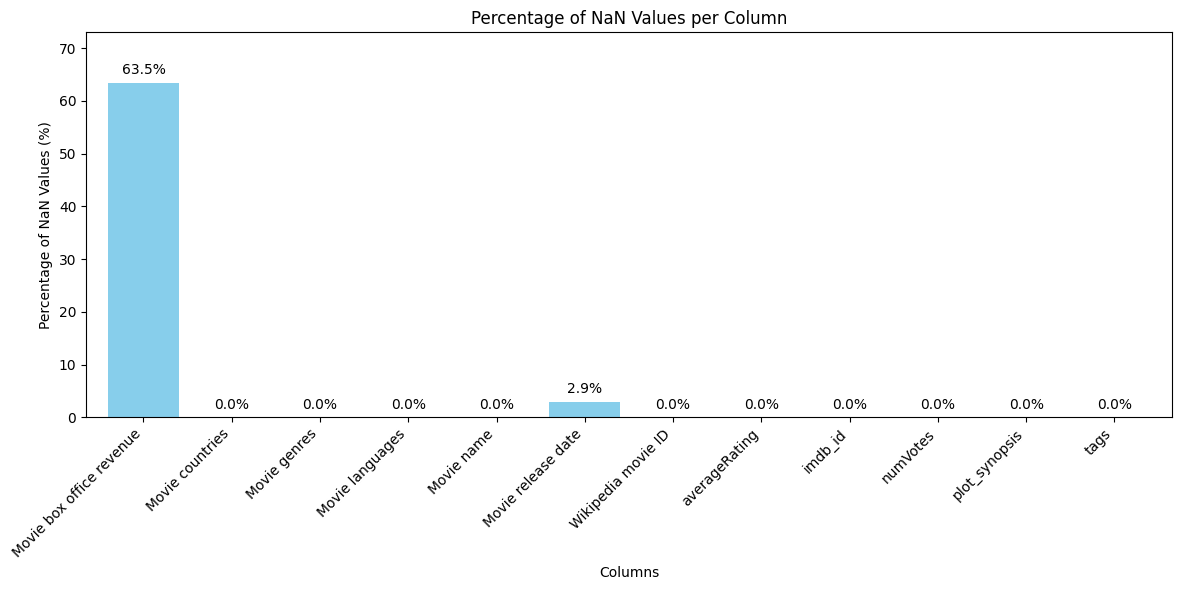

In [59]:
# Calculate percentage of NaN values in each column
na_percentage = (movies_ratings.isna().sum() / len(movies_ratings)) * 100
na_percentage = na_percentage.sort_index()

# Plot
plt.figure(figsize=(12, 6))
bars = na_percentage.plot(kind='bar', color='skyblue', width=0.8)  

# Add percentage labels on top of each bar
for i, value in enumerate(na_percentage):
    plt.text(i, value + 1, f'{value:.1f}%', ha='center', va='bottom', fontsize=10)  

plt.xlabel('Columns')
plt.xticks(rotation=45, ha='right')  
plt.ylabel('Percentage of NaN Values (%)')
plt.ylim(top =73)
plt.title('Percentage of NaN Values per Column')
plt.tight_layout()  

plt.show()


Two columns contain Missing values: 
- `Movie box office revenue` which has 2.9% of missing values
- `Movie release date` with 63.5% of missing values is very problematic, since thsi feature is used to answer the research questions we will try to find external information to fill the gaps.

### Handling Nans for Movie release dates
We remove movies with no information on Movie release dates since we are intereseted in the release years

In [63]:
# Drop all movies with no Movie release dates
movies_df_cleaned = movies_ratings.dropna(subset=['Movie release date'])

# Check missing values
movies_df_cleaned['Movie release date'].isna().any()
print(movies_ratings.shape[0]-movies_df_cleaned.shape[0], "movies have no release dates and were removed from the dataset")

433 movies have no release dates and were removed from the dataset


### Handling Nans for Movie box office revenue
Since teh number of NaNs is more significant we try to enrich the dataset with data from IMbD

After realizing the high number of NaN values in the box-office revenue column, we decided to complete this data as much as possible with the IMDB library.

In [ ]:
def clean_ids(s, pattern=' '): #remove in string a pattern
    s = str(s).replace(pattern, '')
    return s

#Get the right imdb_id by removing 'tt' in front of IDs
movies_df_cleaned['imdb_id'] = movies_df_cleaned['imdb_id'].apply(lambda x : clean_ids(x, 'tt'))

#Create a dic telling if 'Movie box office revenue' is a NaN or not
isnan_dic = movies_df_cleaned['Movie box office revenue'].isna()

def get_box_office(imdb_ID): #return the box-office revenue for a specific imdb_id
    ia = IMDb()
    movie = ia.get_movie(imdb_ID)
    box_office = movie.get('box office')
    if box_office and 'Cumulative Worldwide Gross' in box_office:
        box_office_num = float(re.sub(r'[^\d.]', '', box_office['Cumulative Worldwide Gross']))
        #box_office_num = float(box_office['Cumulative Worldwide Gross'].replace('$', '').replace(',', ''))
        return box_office_num
    return None  # Return None if no box office data is found


In [ ]:
#Quick checks
index_case1 = 0
index_case2 = 1
index_case3 = 2
print(f"The initial box-office was {movies_df_cleaned.iloc[index_case1]['Movie box office revenue']}, we find with Imdb library {get_box_office(movies_df_cleaned.iloc[index_case1]['imdb_id'])}")
print(f"The initial box-office was {movies_df_cleaned.iloc[index_case2]['Movie box office revenue']}, we find with Imdb library {get_box_office(movies_df_cleaned.iloc[index_case2]['imdb_id'])}")
print(f"The initial box-office was {movies_df_cleaned.iloc[index_case3]['Movie box office revenue']}, we find with Imdb library {get_box_office(movies_df_cleaned.iloc[index_case3]['imdb_id'])}")

We are indeed getting more box-office data, and recovering the same value in cases where we already had data ! Let's now apply the function on the whole dataset.

In [ ]:
#Apply on the whole dataset
run = False #Run is very long, directly use the file in Data directory
if run:
    box_offices = movies_df_cleaned.apply(lambda x: get_box_office(x['imdb_id']) if isnan_dic[x.name] else x['Movie box office revenue'], axis=1) #Try to get the box-office from Imdb only if we don't already have it
    movies_df_cleaned.insert(len(movies_df_cleaned.columns), 'IMDB Box-office', box_offices)

In [ ]:
movies_synopsis_comp = movies_df_cleaned.copy()

In [ ]:
#Here is the file with completed box-office from Imdb (last column)
movies_synopsis_comp = pd.read_csv('Data/movies_synopsis_comp.csv')
display(movies_synopsis_comp.head())

### Comment

We completed some of the missing data, but how much did we improve ?

In [ ]:
#Improvement in NaN values in box-office
na_percentage_box_init = (movies_synopsis_comp['Movie box office revenue'].isna().sum() / len(movies_synopsis_comp)) * 100
na_percentage_box_imdb = (movies_synopsis_comp['IMDB Box-office'].isna().sum() / len(movies_synopsis_comp)) * 100
print(f"We went from {round(na_percentage_box_init,2)}% of NaN values to {round(na_percentage_box_imdb,2)}%.")

In [ ]:
#Remove the old revenue column as we don't need it anymore
movies_synopsis_comp.drop('Movie box office revenue', axis=1, inplace=True)

### Comment
The increase is a bit deceiving. The IMDB library is missing a lot of box-offices too. We suspect the IMDB library to mabe block when there are too many requests, giving more NaN values than there actually are. In the end that's still an increase of 24% in box-office data size, which will help us for our analysis.

## COMMENT HOW HANDLE MISSING VALUES

# PART 2: Data Analysis

### A CHANGER AVEC movie_final = movies_synopsis_comp.copy() MAIS J'AVAIS PAS LE DATASET

In [ ]:
movie_final = movies_df_cleaned.copy()

### Movies' genres exploration

In [ ]:
all_genres = movie_final['Movie genres'].explode()

genres_counts = all_genres.value_counts()

num_unique_genre = all_genres.nunique()
print("Number of unique genres:", num_unique_genre)

In [ ]:
# Plot the number of movies per top 30 genres
plt.figure(figsize=(10, 8))
bars = genres_counts.head(30).sort_values(ascending=True).plot(kind='barh', color='lightgreen')

for index, value in enumerate(genres_counts.head(30).sort_values(ascending=True)):
    plt.text(value, index, str(value), va='center')

plt.xlabel('Number of Movies', fontsize=16)
plt.ylabel('Genres', fontsize=16)
plt.title('Number of Movies per Genre', fontsize=16)  

plt.show()

Drama is the clear leader when it comes to movie genres, followed by Comedy and Romance. This makes sense since these genres appeal to a wide range of audiences. Genres like Thriller, Action, and Documentary are also popular, showing that people enjoy excitement and real-life stories. On the other end, niche genres like 'Cult' and 'Political drama' are much less common, which isn't surprising given their more specific audience.

Here we decided to show only the top 30 genres to keep the chart clear and easy to read.

### Movies Box office exploration

In [ ]:
# Faire plot 

### Movies Ratings exploration

In [ ]:
movie_final['averageRating'].describe()

## QUICK COMMENT

In [ ]:
rating_counts = movie_final['averageRating'].value_counts().sort_index()

# Plotting the bar chart
plt.figure(figsize=(10, 6))
plt.bar(rating_counts.index, rating_counts.values)
plt.xlabel('Average Rating')
plt.ylabel('Number of Movies')
plt.title('Number of Movies by Rating')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

## COMMENTer + faire un plot plus joli ??

### Movies countries exploration

In [ ]:
all_countries = movie_final['Movie countries'].explode()

countries_counts = all_countries.value_counts() 

print(countries_counts)

In [ ]:
num_unique_countries = all_countries.nunique()
print("Number of unique countries:", num_unique_countries)

In [ ]:
# Plot the number of movies per top 30 country
plt.figure(figsize=(10, 8))
bars = countries_counts.head(30).sort_values(ascending=True).plot(kind='barh', color='lightcoral')

for index, value in enumerate(countries_counts.head(30).sort_values(ascending=True)):
    plt.text(value, index, str(value), va='center')

plt.xlabel('Number of Movies', fontsize=16)
plt.ylabel('Countries', fontsize=16)
plt.title('Number of Movies per Country', fontsize=16)  
plt.xscale('log')
plt.show()

The United States has the most movies by far, showing its huge impact on the film industry. The United Kingdoms and France come next, thanks to Bollywood and British cinema. Germany, India and Canada also produce a lot of movies. The numbers drop as you go down the list, with fewer movies made in other countries.

We decided to show only the top 30 countries to keep the chart clear and easy to read. For better readibility we used a log scale on the x axis.

### Movies languages exploration

In [ ]:
all_languages = movie_final['Movie languages'].explode()

language_counts = all_languages.value_counts()

print(language_counts)

In [ ]:
num_unique_languages = all_languages.nunique()
print("The dataset contains ", num_unique_languages, "unique languages.")

In [ ]:
# Plot the number of movies per language 
plt.figure(figsize=(10, 8))
bars = language_counts.head(20).sort_values(ascending=True).plot(kind='barh', color='lightblue')

for index, value in enumerate(language_counts.head(20).sort_values(ascending=True)):
    plt.text(value, index, str(value), va='center')

plt.xlabel('Number of Movies',fontsize=14)
plt.ylabel('Languages',fontsize=14)
plt.title('Number of Movies of top 20 Languages', fontsize=14)
plt.xscale('log')
plt.show()

As previously seen, English is largely dominant. This can be attributed to its role as a global lingua franca, making films more accessible to international audiences. Additionally, major movie industries in countries like the United Kingdom and other English-speaking regions contribute to the high number of English-language films.

For better visibility, we chose to display only the top 20 languages in this chart. It is also noticeable that the number of movies per language drops off quickly after the most common languages, highlighting the dominance of a few major languages in movie production and a long tail of less commonly represented languages. For better readibility we used a log scale on the x axis.

### Movies release year exploration

Here we do a general analysis about the total number of movies released each year.

In [ ]:
all_years = movie_final['Movie release date'].explode()
years_counts = all_years.value_counts()

In [ ]:
plt.figure(figsize=(10, 8))  
plot_years_counts = all_years.value_counts().sort_index().plot(kind='bar')
plt.xlabel('Years', fontsize=16 )
plt.ylabel('Number of Movies', fontsize=16)
plt.title('Number of Movies per Year', fontsize=16)

plt.xticks(range(0, len(all_years.value_counts().sort_index()), 5), 
           all_years.value_counts().sort_index().index[::5], 
           rotation=45)

plt.show()

The movie production has grown steadily over time, with a big jump starting in the 1990s and peaking in the early 2000s. The increase after the 1980s is likely due to better technology and more people making movies around the world. The early years have fewer movies because the film industry was just getting started.

### Movies per decade for most important countries

In [ ]:
# Get top 10 countries releasing movies
top_10_countries = countries_counts.head(10).index

# Get one country per row (since some movies contain more that one countries)
expanded_df = movie_final.explode('Movie countries')

top_countries_df = expanded_df[expanded_df['Movie countries'].isin(top_10_countries)]

In [ ]:
top_countries_df['Decade'] = (top_countries_df['Movie release date'] // 10) * 10

# Group by decade and country, count the number of movies
movies_per_decade_countries = top_countries_df.groupby(['Decade', 'Movie countries']).size().unstack(fill_value=0)

In [ ]:
# Create the interactive figure
fig = go.Figure()

for country in movies_per_decade_countries.columns:
    fig.add_trace(go.Bar(
        x=movies_per_decade_countries.index,  # Decades
        y=movies_per_decade_countries[country],  # Number of movies
        name=country,
        hovertemplate='Percentage: %{customdata:.2f}%',
        customdata=100 * movies_per_decade_countries[country] / movies_per_decade_countries.sum(axis=1)
    ))

fig.update_layout(
    title='Proportion of Movies Produced by Top 10 Countries per Decade',
    xaxis_title='Decade',
    yaxis_title='Number of Movies',
    barmode='stack',
    legend_title='Country',
    hovermode='x'
)

fig.show()


The U.S. consistently dominates movie production across all decades, though its share decreases over time from near-total dominance in the early 20th century to around 40-50% in the later decades. Other countries, such as India, the UK, and France, start contributing more significantly from the 1950s onward, indicating a diversification in global movie production over the decades.

### Do the genres of the released movies vary on different decades?

In [ ]:
# Get top 20 genres releasing movies
top_20_genres = genres_counts.head(20).index

# Get one country per row
expanded_df_genre = movie_final.explode('Movie genres')

# the top 20
top_genres_df_20 = expanded_df_genre[expanded_df_genre['Movie genres'].isin(top_20_genres)]

movies_per_year_genres_20 = top_genres_df_20.groupby(['Movie genres', 'Movie release date']).size().unstack(fill_value=0)
movies_per_decade_genres_20 = movies_per_year_genres_20.groupby((movies_per_year_genres_20.columns // 10) * 10, axis=1).sum()

movies_per_decade_genres_20_percentage = movies_per_decade_genres_20.div(movies_per_decade_genres_20.sum(axis=1), axis=0)

We decide to keep only the top 20 genres so that our graph stay clear but you can adjust this number if needed. 

In [ ]:
movies_per_decade_by_genre = movies_per_decade_genres_20.T

# Ensure your DataFrame `movies_per_decade_by_genre_normalized` is defined and normalized
movies_per_decade_by_genre_normalized = movies_per_decade_by_genre.div(movies_per_decade_by_genre.sum(axis=1), axis=0)

In [ ]:
# Create an interactive figure
fig = go.Figure()

# Iterate through each decade and create a bar plot for it
for decade in movies_per_decade_by_genre_normalized.index:
    fig.add_trace(go.Bar(
        x=movies_per_decade_by_genre_normalized.columns,
        y=movies_per_decade_by_genre_normalized.loc[decade],  # Convert to percentage
        name=f'{decade}s',
        visible=False  # Initially set all traces to invisible
    ))

# Set the first decade to be visible
fig.data[0].visible = True

# Create the slider steps
steps = []
for i, decade in enumerate(movies_per_decade_by_genre_normalized.index):
    step = dict(
        method="update",
        args=[{"visible": [False] * len(fig.data)}],  # Hide all traces
        label=f"{decade}s"
    )
    step["args"][0]["visible"][i] = True  # Set the current decade's trace to visible
    steps.append(step)

# Create slider
sliders = [dict(
    active=0,
    currentvalue={"prefix": "Decade: "},
    pad={"t": 50},
    steps=steps
)]

# Update the layout to include the slider
fig.update_layout(
    sliders=sliders,
    title='Proportion of Movies Released by Genre in Each Decade',
    xaxis_title='Genre',
    yaxis_title='Percentage of Movies',
    yaxis=dict(tickformat=".1%"),
    barmode='group'
)

# Show the plot
fig.show()


## COMMENTER

In [ ]:
ig = go.Figure()

for genre in movies_per_decade_genres_20_percentage.index:
    fig.add_trace(go.Bar(
        x=movies_per_decade_genres_20_percentage.columns,  # Decades
        y=movies_per_decade_genres_20_percentage.loc[genre],  # Percentage values for each decade
        name=genre,
        visible=False  
    ))

fig.data[0].visible = True

# Create the slider steps for each genre
steps = []
for i, genre in enumerate(movies_per_decade_genres_20_percentage.index):
    step = dict(
        method="update",
        args=[{"visible": [False] * len(fig.data)}],  
        label=genre
    )
    step["args"][0]["visible"][i] = True  
    steps.append(step)

# Create slider
sliders = [dict(
    active=0,
    currentvalue={"prefix": "Genre: "},
    pad={"t": 50},
    steps=steps
)]

# Update the layout to include the slider
fig.update_layout(
    sliders=sliders,
    title='Proportion of Movies Released per Decade by Selected Genre',
    xaxis_title='Decade',
    yaxis_title='Percentage of Movies',
    yaxis=dict(tickformat=".1%"),
    barmode='group'
)

# Show the plot
fig.show()


# Part 3: Latent Dirichlet Allocation (LDA)
To group movies together based on something more precise than their genre, we will use Latent Dirichlet Allocation. LDA offers a way to cluster together movies that reflect similar themes, based on textual descriptions. The model is based on unsupervised learning, as the subjects are not known. However the movie summaries only give us too few informations to use LDA. That's why we will extract the synopsis of the movies through another dataset called "Movie Plot Synopses with Tags" (MPST). Those synopsis are around 10 times longer than the summaries, giving way more informations to the LDA model.

## 3.1 Can we observe movies' topics using LDA?

### Preprocessing
Removing stop words and names before using LDA is important as those very frequent words are not used to predict themes + lowercase 

**Note:** The following cell performs named entity removal and stopword filtering on movie synopses. It takes a while to run, since it processes a large dataset. To skip this cell you can use the preprocessed sentences saved in `Data/processed_sentences.plk` instead by setting `run_processing` to `False`.


In [22]:
## To put in a python file

nlp = spacy.load("en_core_web_sm")

def remove_named_entities(text):
        doc = nlp(text)
        return ' '.join([token.text for token in doc if token.ent_type_ != "PERSON"])  # Exclude PERSON entities



def synopses_processing(sentences):

    # ADD DOCSTRING
    # Load the spaCy model to remove named entities
    
    stop_words = set(stopwords.words('english'))
    
    # Remove named entities
    cleaned_sentences= [remove_named_entities(doc) for doc in sentences]
    print("After removing names their are", len(cleaned_sentences), "sentences")
    
    # Remove stop words and lowercase word
    processed_sentences = [
        [word for word in word_tokenize(sentence.lower()) if word.isalnum() and word not in stop_words]
        for sentence in cleaned_sentences
    ]

    return processed_sentences


In [21]:
# Set this to False to use precomputed processed_sentences.plk
run_processing = False

if run_processing:

    # Get all synopses
    sentences = movies_synopsis['plot_synopsis'].tolist()

    # Lower case, Remove stop words and named entities
    processed_sentences = synopses_processing(sentences)
    
    # Save processed sentences to a file
    with open("data/processed_sentences.pkl", "wb") as file:
        pickle.dump(processed_sentences, file)
else:
    # Load all processed data
    with open("data/processed_sentences.pkl", "rb") as file:
        processed_sentences = pickle.load(file)


**Note:** The following cell builds a dictionary from the processed sentences, converts those sentences into a bag-of-words representation, and then trains an LDA model to extract 10 topics from the text data. It takes a while to run, since it processes a large dataset. To skip this cell you can use the precomputed model saved in `Data/lda_model.model` instead by setting `run_processing` to `False`.

### LDA model

In [15]:
# Set this to False to use precomputed processed_sentences.plk
run_processing = False

if run_processing:
    # Maps each word to a unique integer ID
    dictionary = Dictionary(processed_sentences)
    
    # Convert sentences into a bags of words (BoW)
    corpus = [dictionary.doc2bow(sentence) for sentence in processed_sentences]
    
    # Train LDA model
    lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=10, random_state=42, passes=10, iterations=50)

    # Save dic and model
    lda_model.save("src/models/lda_model.model")
    dictionary.save("src/models/dictionary.dict")
else:
    lda_model = LdaModel.load("src/models/lda_model.model")

### Resulting Topcis
Let's now look at what 10 topics the movies were clustered in

In [16]:
for topic_id, topic_words in lda_model.print_topics(num_words=7):
    print(f"Topic {topic_id}: {topic_words}")

Topic 0: 0.016*"police" + 0.008*"car" + 0.007*"man" + 0.007*"kill" + 0.007*"killed" + 0.007*"house" + 0.005*"finds"
Topic 1: 0.005*"one" + 0.004*"war" + 0.004*"team" + 0.004*"men" + 0.003*"ship" + 0.003*"escape" + 0.003*"killed"
Topic 2: 0.022*"hamlet" + 0.018*"king" + 0.012*"macbeth" + 0.009*"claudius" + 0.006*"prince" + 0.006*"banquo" + 0.005*"act"
Topic 3: 0.007*"father" + 0.005*"love" + 0.005*"family" + 0.005*"one" + 0.005*"life" + 0.005*"new" + 0.005*"mother"
Topic 4: 0.007*"back" + 0.005*"town" + 0.005*"one" + 0.005*"men" + 0.004*"find" + 0.004*"man" + 0.004*"away"
Topic 5: 0.012*"ship" + 0.010*"island" + 0.010*"boat" + 0.008*"uncle" + 0.008*"treasure" + 0.008*"captain" + 0.007*"one"
Topic 6: 0.012*"sir" + 0.011*"beast" + 0.007*"beauty" + 0.007*"merchant" + 0.006*"children" + 0.006*"heathcliff" + 0.005*"love"
Topic 7: 0.008*"money" + 0.008*"get" + 0.007*"tells" + 0.006*"back" + 0.006*"car" + 0.005*"one" + 0.005*"gets"
Topic 8: 0.012*"tells" + 0.009*"back" + 0.007*"says" + 0.007*"

### Is this approach feasible with our data?
This approcah seems promising! With very basic preprocessing can already interpret some themes:


| Topic | Keywords                       | Theme           |
|-------|--------------------------------|-----------------|
| 0     | Police, Kill, Detective        | Detective       |
| 1     | War, Team                      | War             |
| 2     | Hamlet, Macbeth                | Shakespeare     |
| 3     | Father, Love                   | Family          |
| 4     | Town, Sheriff, Horse           | Western         |
| 5     | Ship, Treasure                 | Pirate          |
| 6     | Prince, Castle                 | Fairy Tale      |
| 7     | Money, Job                     | Business        |
| 8     | ?                              | ?               |
| 9     | ?                              | ?               |

### Observations and Improvements
But we also observe that this still has room for improvement:

- Topics 9 still carries many names thus for further analysis the `named entity removal` step should be fine tuned. 

- `Lemmatization` should be applied to avoid reoccurences of declinaison of the same word (e.g killed and kill in topic 0).

- The `parameters` such as number of topics, passes and the number of iterations are not chosen optimally which leaves room for improvement.  